 importing module

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from matplotlib import colors
import seaborn as sns
import statistics
from datetime import date, timedelta,time,datetime
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging


In [2]:
#pip install tslearn 
#!pip install yellowbrick

In [3]:
pd.options.display.float_format = '{:.2f}'.format

In [4]:
INTERVAL = 3
CLUSTERINHG =3
SEED = 42

loading data 

In [5]:
users = pd.read_pickle("users_date_df.pkl")
users.head(1)

,user_id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9
0,SlcW7YT835JSzh22o7zRCA==,False,True,False,False,False,False,False,True,True


In [6]:
m=users.mode(axis=1)
users_df = users.assign(status_day_sale=False,count=users.eq(False, axis=0).sum(axis=1))
users_df.head(1)

,user_id,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,status_day_sale,count
0,SlcW7YT835JSzh22o7zRCA==,False,True,False,False,False,False,False,True,True,False,6


In [7]:
users_df[users_df['count']<=7]['user_id']
len(users_df[users_df['count']<=7]['user_id'])

8361

In [8]:
retail = pd.read_pickle("digikala_retail_cleaned.pkl")
# Convert to datetime to proper datatype
retail['date'] = pd.to_datetime(retail['date'],format='%Y-%m-%d %H:%M:%S')
retail.head(1)

,order_id,user_id,variant_id,product_id,quantity,price,date,city_id,city_name,state_id,state_name
0,262108413,SlcW7YT835JSzh22o7zRCA==,922274,406523,1,139000,2018-08-20 23:59:02,1698,تهران,9,تهران


In [9]:
my_user_id = users_df[users_df['count']<=7]['user_id'].values
len(my_user_id)

8361

In [10]:
retail = retail[retail['user_id'].isin(my_user_id)]

In [11]:
sdate = retail.date.min()
edate = retail.date.max()
f' min date : {sdate} , max date : {edate} '

' min date : 2018-08-12 06:21:26 , max date : 2018-08-20 23:59:02 '

In [12]:
base =retail.date.min()
delta = (edate - sdate).days + 1 
main_date_list = [(base + timedelta(days=x)).date() for x in range(delta)]
date_list=main_date_list[::INTERVAL]

In [13]:
date_list

[datetime.date(2018, 8, 12),
 datetime.date(2018, 8, 15),
 datetime.date(2018, 8, 18)]

In [14]:
# delta = edate - sdate       # as timedelta

# for i in range(delta.days + 1):
#     day = sdate + timedelta(days=i)
#     print(day)

In [15]:
retail['d']= retail.date.dt.date


In [16]:
df_list = []
def interval_order(dayDate):
    start_interval = dayDate
    end_interval = dayDate + timedelta(INTERVAL)
    mask = (retail['date'] >= datetime.combine(start_interval, time.min)) & (retail['date'] < datetime.combine(end_interval, time.max))
    df_list.append(pd.DataFrame(retail.loc[mask].copy()))
    print(retail.loc[mask].shape)

In [17]:
for date in date_list :interval_order(date)

(30169, 12)
(30884, 12)
(26548, 12)


In [18]:
 type(df_list[0])

pandas.core.frame.DataFrame

In [19]:
# Compute the difference between max date and transaction date
for i in range(len(date_list)):
    df_list[i]['Diff'] = ( df_list[i]['d']-date_list[i]).dt.days
    print(df_list[i]['Diff'].value_counts())


1    8034
2    7836
3    7830
0    6469
Name: Diff, dtype: int64
3    10869
0     7830
1     6148
2     6037
Name: Diff, dtype: int64
0    10869
2     7889
1     7790
Name: Diff, dtype: int64


In [20]:
# Compute last transaction date to get the recency of customers
rfm_r_list = []
for df in df_list:
    rfm_r = df.groupby('user_id')['Diff'].min()
    rfm_r = rfm_r.reset_index()
    rfm_r.columns = ['user_id', 'Recency']
    rfm_r_list.append(rfm_r)
rfm_r_list[0].head()

,user_id,Recency
0,++aFMHHDKluZF2DJXQ4VVg==,0
1,+/4x52C5GE58tU5a4oiIoA==,3
2,+0PlX9fbkOLljCIpz6XPLw==,1
3,+0Z8Z8H1GzgQNkXLT1XZOQ==,2
4,+1c7nwokadfFgshMPbwQPQ==,2


In [21]:
# New Attribute : Length
rfm_l_list = []
for df in df_list:
    rfm_l=(df.groupby('user_id')['date'].max()-df.groupby('user_id')['date'].min()).dt.days
    rfm_l = rfm_l.reset_index()
    rfm_l.columns = ['user_id', 'Length']
    print(rfm_l['Length'].value_counts())
    rfm_l_list.append(rfm_l)
rfm_l_list[0].head(2)

0    4581
1     886
2     597
3     186
Name: Length, dtype: int64
0    4653
1     685
2     658
3     308
Name: Length, dtype: int64
0    4634
1     804
2     363
Name: Length, dtype: int64


,user_id,Length
0,++aFMHHDKluZF2DJXQ4VVg==,2
1,+/4x52C5GE58tU5a4oiIoA==,0


In [22]:
# New Attribute : Monetary
rfm_m_list = []
for df in df_list:    
    df['Monetary']= retail['quantity']*retail['price']
    rfm_m = df.groupby('user_id')['Monetary'].sum()
    rfm_m = rfm_m.reset_index()
    rfm_m.columns = ['user_id', 'Monetary']
    rfm_m_list.append(rfm_m)
rfm_m_list[0].head()

,user_id,Monetary
0,++aFMHHDKluZF2DJXQ4VVg==,880000
1,+/4x52C5GE58tU5a4oiIoA==,7780000
2,+0PlX9fbkOLljCIpz6XPLw==,1139800
3,+0Z8Z8H1GzgQNkXLT1XZOQ==,26098000
4,+1c7nwokadfFgshMPbwQPQ==,10220000


In [23]:
# New Attribute : Frequency
rfm_f_list= []
for df in df_list:
    
    rfm_f = df.groupby('user_id')['order_id'].nunique()
    rfm_f = rfm_f.reset_index()
    rfm_f.columns = ['user_id', 'Frequency']
    #print(rfm_f['Frequency'].value_counts())
    rfm_f_list.append(rfm_f)
rfm_f_list[0].head()

,user_id,Frequency
0,++aFMHHDKluZF2DJXQ4VVg==,2
1,+/4x52C5GE58tU5a4oiIoA==,1
2,+0PlX9fbkOLljCIpz6XPLw==,1
3,+0Z8Z8H1GzgQNkXLT1XZOQ==,1
4,+1c7nwokadfFgshMPbwQPQ==,1


In [24]:
rfm_p_list = []
for df in df_list:
    dates_df =df.groupby('user_id').agg(dates=('date','unique'))
    dates_df['length_dates']=dates_df.dates.str.len()
    dates_df = dates_df.reset_index()
    dates_df.columns=['user_id','dates','length_dates']
    rfm_p_list.append(dates_df)


In [25]:
def order_date_day_std(x):
    if len(x) >1:
        diff_dates = []
        x= np.asarray(sorted(x))
        
        for i in range(x.shape[0]):
            
            #time_delta_h = (x[i+1] - x[i]).astype('timedelta64[h]').astype(int)
            time_delta_d = (x[i+1] - x[i]).astype('timedelta64[D]').astype(int)
            diff_dates.append(time_delta_d)
            
            if len(x) == i+2 : break
        if len(diff_dates)== 1: return 0
        return statistics.stdev(diff_dates)
    else: return 0

In [26]:
for dates_df in rfm_p_list:
    dates_df['Periodicity_day'] = dates_df['dates'].map(order_date_day_std)
    
rfm_p_list[0]['Periodicity_day'].value_counts()

0.00    6106
1.41      94
1.00      29
2.00      18
1.73       3
Name: Periodicity_day, dtype: int64

In [27]:
lrfmp_df_list = []
for i in range(INTERVAL):
    df = pd.DataFrame(retail['user_id'].unique())
    df.columns = ['user_id']
    #df= df.set_index('user_id')
    lrfmp_df_list.append(df)

In [28]:
for i in range(INTERVAL):
    result = lrfmp_df_list[i]
    result = pd.merge(result,
                 rfm_l_list[i],
                 on='user_id', 
                 how='left')
    result = pd.merge(result,
                 rfm_r_list[i],
                 on='user_id', 
                 how='left')
    result = pd.merge(result,
                 rfm_f_list[i],
                 on='user_id', 
                 how='left')
    result = pd.merge(result,
                 rfm_m_list[i],
                 on='user_id', 
                 how='left')
    result = pd.merge(result,
                 rfm_p_list[i][['user_id','Periodicity_day']],
                 on='user_id', 
                 how='left')
    lrfmp_df_list[i]=result
    
    

In [29]:
lrfmp_df_list[0]

,user_id,Length,Recency,Frequency,Monetary,Periodicity_day
0,SlcW7YT835JSzh22o7zRCA==,0.00,1.00,1.00,6220000.00,0.00
1,dLQImlfXMsgSub4OcfJpGg==,NaN,NaN,NaN,NaN,NaN
2,J8hrr47CZzyR/nasPNaEcA==,0.00,0.00,1.00,2090000.00,0.00
3,Fh8s6YZs97rvUr/dowRGYA==,3.00,0.00,2.00,4960000.00,0.00
4,Ca2NTs2HdZHIHq1uwiAX4Q==,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
8356,kEC76SpzFfW8FwMhUK/Mqg==,0.00,0.00,2.00,7213500.00,0.00
8357,afqB81CeEw/E1xla7P8tiA==,0.00,0.00,2.00,5880000.00,0.00
8358,weBOQhMC/VjXvU9QhVlgow==,0.00,0.00,2.00,2540000.00,0.00
8359,lLngz0sR/tMLwwXeWzsXuA==,0.00,0.00,3.00,2742000.00,0.00


In [30]:
lrfmp_df_list[2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8361 entries, 0 to 8360
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   user_id          8361 non-null   object 
 1   Length           5801 non-null   float64
 2   Recency          5801 non-null   float64
 3   Frequency        5801 non-null   float64
 4   Monetary         5801 non-null   float64
 5   Periodicity_day  5801 non-null   float64
dtypes: float64(5), object(1)
memory usage: 457.2+ KB


In [31]:
for i in range(len(lrfmp_df_list)):
    lrfmp_df_list[i] = lrfmp_df_list[i].fillna(0)
    lrfmp_df_list[i] = lrfmp_df_list[i].set_index('user_id')

lrfmp_df_list[2].info() # chekc fillna is workly true

<class 'pandas.core.frame.DataFrame'>
Index: 8361 entries, SlcW7YT835JSzh22o7zRCA== to AHohyltHPsg96jIAVbS0pw==
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Length           8361 non-null   float64
 1   Recency          8361 non-null   float64
 2   Frequency        8361 non-null   float64
 3   Monetary         8361 non-null   float64
 4   Periodicity_day  8361 non-null   float64
dtypes: float64(5)
memory usage: 391.9+ KB


In [32]:
columns_name = lrfmp_df_list[0].columns
lrfmp_df_scaled_list = []

for lrfmp_df in lrfmp_df_list:
     # fit_transform
    # Instantiate
    scaler = StandardScaler()
    lrfmp_df_scaled = scaler.fit_transform(lrfmp_df)
    lrfmp_df_scaled_list.append(lrfmp_df_scaled)
# lrfmp_df_scaled.shape
lrfmp_df_scaled_list[0]

array([[-0.44970217,  0.05028506, -0.17103139,  0.15212199, -0.12976807],
       [-0.44970217, -0.87577964, -0.89034401, -0.36424876, -0.12976807],
       [-0.44970217, -0.87577964, -0.17103139, -0.19074154, -0.12976807],
       ...,
       [-0.44970217, -0.87577964,  0.54828122, -0.15338353, -0.12976807],
       [-0.44970217, -0.87577964,  1.26759384, -0.13661393, -0.12976807],
       [-0.44970217, -0.87577964,  0.54828122,  0.26585638, -0.12976807]])

In [33]:
for i in range(len(lrfmp_df_scaled_list)):
    lrfmp_df_scaled_list[i] = pd.DataFrame(lrfmp_df_scaled_list[i])
    lrfmp_df_scaled_list[i].columns = columns_name


In [34]:
lrfmp_df_scaled_list[0]

,Length,Recency,Frequency,Monetary,Periodicity_day
0,-0.45,0.05,-0.17,0.15,-0.13
1,-0.45,-0.88,-0.89,-0.36,-0.13
2,-0.45,-0.88,-0.17,-0.19,-0.13
3,3.83,-0.88,0.55,0.05,-0.13
4,-0.45,-0.88,-0.89,-0.36,-0.13
...,...,...,...,...,...
8356,-0.45,-0.88,0.55,0.23,-0.13
8357,-0.45,-0.88,0.55,0.12,-0.13
8358,-0.45,-0.88,0.55,-0.15,-0.13
8359,-0.45,-0.88,1.27,-0.14,-0.13


In [132]:
# Elbow-curve/SSD

ssd = {}
range_n_clusters = [ 3, 4, 5, 6, 8, 10]
for i in range(len(lrfmp_df_scaled_list)):
    ssd_cluster = []
    for num_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
        kmeans.fit(lrfmp_df_scaled_list[i])
        ssd_cluster.append(kmeans.inertia_)
    ssd[i] = ssd_cluster
    
# plot the SSDs for each n_clusters
# plt.plot(ssd)

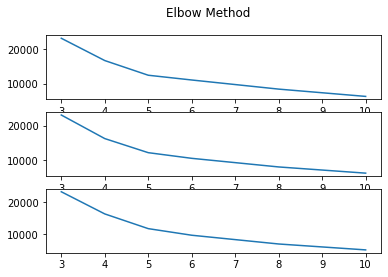

In [133]:
fig, axs = plt.subplots(INTERVAL)
fig.suptitle('Elbow Method')
axs[0].plot(range_n_clusters, ssd[0])
axs[1].plot(range_n_clusters, ssd[1])
axs[2].plot(range_n_clusters, ssd[2])

In [37]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 8, 10]
silhouette = {}
for i in range(len(lrfmp_df_scaled_list)):
    silhouette_score_cluster = []
    for num_clusters in range_n_clusters:

        # intialise kmeans
        kmeans = KMeans(n_clusters=num_clusters, max_iter=100)
        kmeans.fit(lrfmp_df_scaled_list[i])

        cluster_labels = kmeans.labels_

        # silhouette score
        silhouette_avg = silhouette_score(lrfmp_df_scaled, cluster_labels)
        silhouette_score_cluster.append(silhouette_avg)
        #print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    silhouette[i]=silhouette_score_cluster
    

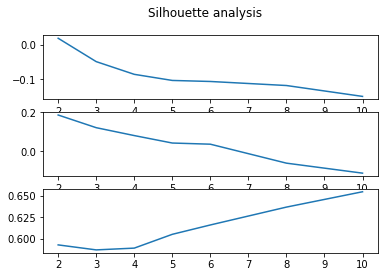

In [38]:
fig, axs = plt.subplots(INTERVAL)
fig.suptitle('Silhouette analysis')
axs[0].plot(range_n_clusters, silhouette[0])
axs[1].plot(range_n_clusters, silhouette[1])
axs[2].plot(range_n_clusters, silhouette[2])

In [39]:
# from yellowbrick.cluster import SilhouetteVisualizer
 
# fig, ax = plt.subplots(6, 2, figsize=(30,30))
# for i in range(len(lrfmp_df_scaled_list)):
#     for k in range(2,6):
#         '''
#         Create KMeans instance for different number of clusters
#         '''
#         km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=42)
#         q, mod = divmod(k, 2)
#         '''
#         Create SilhouetteVisualizer instance with KMeans instance
#         Fit the visualizer
#         '''
#         if i == 1:
#             q+=2
#         if i== 2:
#             q+=4
#         visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#         visualizer.fit(lrfmp_df_scaled_list[0]) 

In [40]:
# Final model with k=CLUSTERINHG
for idx,lrfmp_df in enumerate(lrfmp_df_list):
    kmeans = KMeans(n_clusters=3, max_iter=50)
    kmeans.fit(lrfmp_df_scaled_list[idx])
     # assign the label
    lrfmp_df['Cluster_Id'] = kmeans.labels_


In [41]:
np.unique(kmeans.labels_)

array([0, 1, 2])

In [42]:
lrfmp_df_list[0].groupby(["Cluster_Id"])['Cluster_Id'].value_counts()

Cluster_Id  Cluster_Id
0           0             1604
1           1             6613
2           2              144
Name: Cluster_Id, dtype: int64

In [43]:
lrfmp_df_list[1].groupby(["Cluster_Id"])['Cluster_Id'].value_counts()

Cluster_Id  Cluster_Id
0           0             4615
1           1             2602
2           2             1144
Name: Cluster_Id, dtype: int64

In [44]:
lrfmp_df_list[2].groupby(["Cluster_Id"])['Cluster_Id'].value_counts()

Cluster_Id  Cluster_Id
0           0             1187
1           1             7134
2           2               40
Name: Cluster_Id, dtype: int64

### CLUSTER 0

In [45]:
def color_detector(df):
    print(len(df.Monetary_mean))
    clrs= ['blue']*len(df.Monetary_mean)
    for x in df.Monetary_mean:
        if x==max(df.Monetary_mean):

            clrs[list(df[df.Monetary_mean==x]['Cluster_Id'])[0]]='blue'
            
        elif x==min(df.Monetary_mean):
            clrs[list(df[df.Monetary_mean==x]['Cluster_Id'])[0]]='red'

        else:
            
            if np.isnan(x) : continue
            clrs[df[df.Monetary_mean==x]['Cluster_Id'].index[0]]='green'

        
    return clrs
# color_detector(df)

In [46]:
km_clusters_monetary = pd.DataFrame(lrfmp_df_list[0].groupby(["Cluster_Id"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(lrfmp_df_list[0].groupby(["Cluster_Id"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(lrfmp_df_list[0].groupby(["Cluster_Id"]).Recency.mean())
km_clusters_Length = pd.DataFrame(lrfmp_df_list[0].groupby(["Cluster_Id"]).Length.mean())
km_clusters_Periodicity_day = pd.DataFrame(lrfmp_df_list[0].groupby(["Cluster_Id"]).Periodicity_day.mean())



In [47]:
df = pd.concat([pd.Series(np.unique(kmeans.labels_)), km_clusters_monetary, km_clusters_frequency, km_clusters_recency,km_clusters_Length,km_clusters_Periodicity_day], axis=1)
df.columns = ["Cluster_Id", "Monetary_mean", "Frequency_mean", "Recency_mean","Length_mean","Periodicity_day_mean"]
df.set_index('Cluster_Id')
df= df.sort_values(by=['Monetary_mean'],ascending=False)
df

,Cluster_Id,Monetary_mean,Frequency_mean,Recency_mean,Length_mean,Periodicity_day_mean
0,0,11743750.15,2.77,0.62,1.43,0.00
2,2,9556304.86,3.31,0.22,2.38,1.41
1,1,2490794.47,0.82,1.04,0.00,0.00


In [48]:
rank =1
for i in df['Cluster_Id']:
    lrfmp_df_list[0].loc[lrfmp_df_list[0]['Cluster_Id']==i,'rank_0']=rank
    rank +=1

In [49]:
pd.value_counts(lrfmp_df_list[0]['rank_0'])

3.00    6613
1.00    1604
2.00     144
Name: rank_0, dtype: int64

3


[Text(0, 0, '1.17438e+07'),
 Text(0, 0, '2.49079e+06'),
 Text(0, 0, '9.5563e+06')]

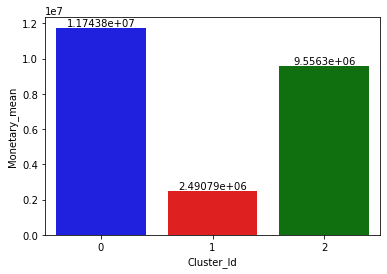

In [50]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Monetary_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '2.76683'), Text(0, 0, '0.821715'), Text(0, 0, '3.3125')]

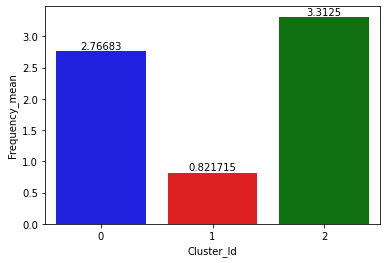

In [51]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Frequency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0.620324'), Text(0, 0, '1.04038'), Text(0, 0, '0.222222')]

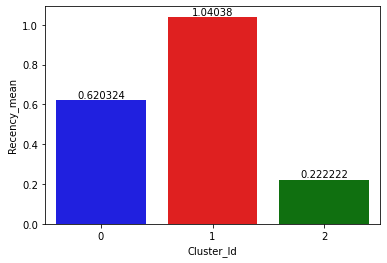

In [52]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Recency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '1.43142'), Text(0, 0, '0'), Text(0, 0, '2.375')]

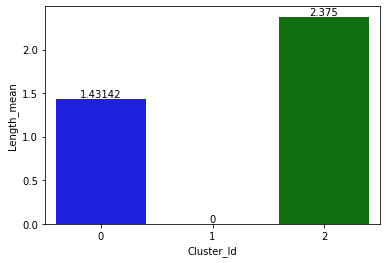

In [53]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Length_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0'), Text(0, 0, '0'), Text(0, 0, '1.41064')]

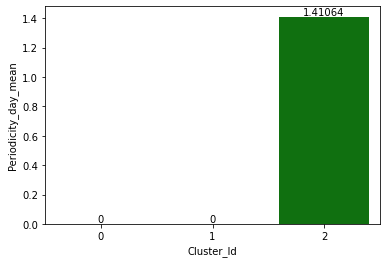

In [54]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Periodicity_day_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


### END CLUSTER 0


In [55]:
# fig, ax = plt.subplots(1,3)
# fig = plt.figure(figsize=(12, 12))
# for i in range(len(lrfmp_df_list)):
#     km_clusters_monetary = pd.DataFrame(lrfmp_df_list[i].groupby(["Cluster_Id"]).Monetary.mean())
#     km_clusters_frequency = pd.DataFrame(lrfmp_df_list[i].groupby(["Cluster_Id"]).Frequency.mean())
#     km_clusters_recency = pd.DataFrame(lrfmp_df_list[i].groupby(["Cluster_Id"]).Recency.mean())
#     #create new df
#     df = pd.concat([pd.Series(np.unique(kmeans.labels_)), km_clusters_monetary, km_clusters_frequency, km_clusters_recency], axis=1)
#     df.columns = ["Cluster_Id", "Monetary_mean", "Frequency_mean", "Recency_mean"]
# #     sns.barplot(x=df.Cluster_Id, y=df.Monetary_mean)
# #     sns.barplot(x=df.Cluster_Id, y=df.Frequency_mean)
# #     sns.barplot(x=df.Cluster_Id, y=df.Recency_mean)
    
#     r1 = ax[0].bar(df.Cluster_Id, df.Monetary_mean,color=('b','r','g'))
#     r2 = ax[1].bar(df.Cluster_Id, df.Frequency_mean,color=('b','r','g'))
#     r3 = ax[2].bar(df.Cluster_Id, df.Recency_mean,color=('b','r','g'))
    

# #     axs[i].barplot(x=df.Cluster_Id, y=df.Monetary_mean)
# #     axs[i].barplot(x=df.Cluster_Id, y=df.Frequency_mean)
# #     axs[i].barplot(x=df.Cluster_Id, y=df.Recency_mean)
    
    

In [56]:
# df1 = lrfmp_df_list[0]
# df1[df1['Cluster_Id']==2].Monetary.value_counts()

### CLUSTER 1


In [57]:
km_clusters_monetary = pd.DataFrame(lrfmp_df_list[1].groupby(["Cluster_Id"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(lrfmp_df_list[1].groupby(["Cluster_Id"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(lrfmp_df_list[1].groupby(["Cluster_Id"]).Recency.mean())
km_clusters_Length = pd.DataFrame(lrfmp_df_list[1].groupby(["Cluster_Id"]).Length.mean())
km_clusters_Periodicity_day = pd.DataFrame(lrfmp_df_list[1].groupby(["Cluster_Id"]).Periodicity_day.mean())
#create new df
df = None
df = pd.concat([pd.Series(np.unique(kmeans.labels_)), km_clusters_monetary, km_clusters_frequency, km_clusters_recency,km_clusters_Length,km_clusters_Periodicity_day], axis=1)
df.columns = ["Cluster_Id", "Monetary_mean", "Frequency_mean", "Recency_mean","Length_mean","Periodicity_day_mean"]

df.set_index('Cluster_Id')
df= df.sort_values(by=['Monetary_mean'],ascending=False)
df

,Cluster_Id,Monetary_mean,Frequency_mean,Recency_mean,Length_mean,Periodicity_day_mean
2,2,13588033.72,3.30,0.29,2.08,0.24
1,1,3596510.09,1.32,2.58,0.05,0.00
0,0,1997410.69,0.73,0.25,0.09,0.00


In [58]:
rank =1
for i in df['Cluster_Id']:
    lrfmp_df_list[1].loc[lrfmp_df_list[1]['Cluster_Id']==i,'rank_1']=rank
    rank +=1

3


[Text(0, 0, '1.99741e+06'),
 Text(0, 0, '3.59651e+06'),
 Text(0, 0, '1.3588e+07')]

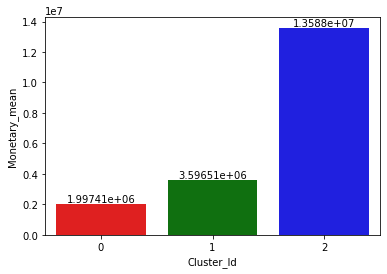

In [59]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Monetary_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0.733044'), Text(0, 0, '1.31937'), Text(0, 0, '3.2972')]

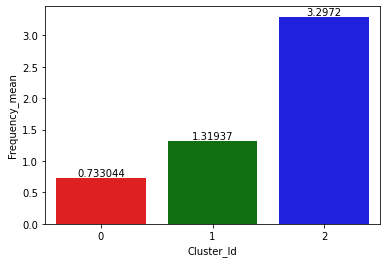

In [60]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Frequency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0.246154'), Text(0, 0, '2.57725'), Text(0, 0, '0.289336')]

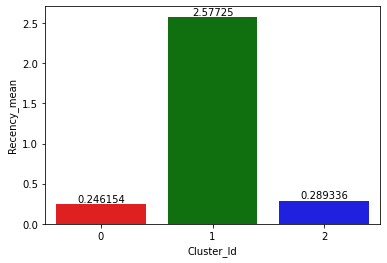

In [61]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Recency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0.0873239'), Text(0, 0, '0.0534204'), Text(0, 0, '2.08304')]

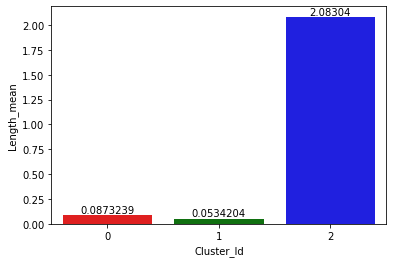

In [62]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Length_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])

3


[Text(0, 0, '0'), Text(0, 0, '0'), Text(0, 0, '0.241754')]

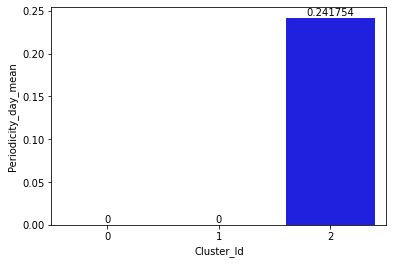

In [63]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Periodicity_day_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])

### END CLUSTER 1

### CLUSTER 2

In [64]:
km_clusters_monetary = pd.DataFrame(lrfmp_df_list[2].groupby(["Cluster_Id"]).Monetary.mean())
km_clusters_frequency = pd.DataFrame(lrfmp_df_list[2].groupby(["Cluster_Id"]).Frequency.mean())
km_clusters_recency = pd.DataFrame(lrfmp_df_list[2].groupby(["Cluster_Id"]).Recency.mean())
km_clusters_Length = pd.DataFrame(lrfmp_df_list[2].groupby(["Cluster_Id"]).Length.mean())
km_clusters_Periodicity_day = pd.DataFrame(lrfmp_df_list[2].groupby(["Cluster_Id"]).Periodicity_day.mean())

#create new df
df = None
df = pd.concat([pd.Series(np.unique(kmeans.labels_)), km_clusters_monetary, km_clusters_frequency, km_clusters_recency,km_clusters_Length,km_clusters_Periodicity_day], axis=1)
df.columns = ["Cluster_Id", "Monetary_mean", "Frequency_mean", "Recency_mean","Length_mean","Periodicity_day_mean"]
df.set_index('Cluster_Id')
df= df.sort_values(by=['Monetary_mean'],ascending=False)
df

,Cluster_Id,Monetary_mean,Frequency_mean,Recency_mean,Length_mean,Periodicity_day_mean
0,0,12366221.11,3.16,0.22,1.22,0.00
2,2,8306232.50,3.27,0.00,2.00,1.32
1,1,2237064.27,0.80,0.56,0.00,0.00


In [65]:
rank =1
for i in df['Cluster_Id']:
    lrfmp_df_list[2].loc[lrfmp_df_list[2]['Cluster_Id']==i,'rank_2']=rank
    rank +=1

In [66]:
km_clusters_recency

,Recency
Cluster_Id,
0,0.22
1,0.56
2,0.00


In [67]:
lrfmp_df_list[2].groupby(["Cluster_Id"]).Recency.value_counts()

Cluster_Id  Recency
0           0.00        937
            1.00        241
            2.00          9
1           0.00       4410
            1.00       1486
            2.00       1238
2           0.00         40
Name: Recency, dtype: int64

3


[Text(0, 0, '1.23662e+07'),
 Text(0, 0, '2.23706e+06'),
 Text(0, 0, '8.30623e+06')]

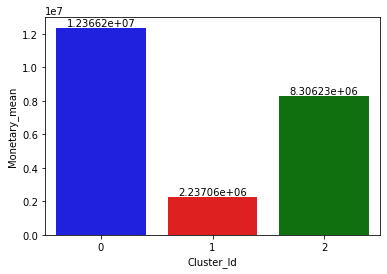

In [68]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Monetary_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '3.16428'), Text(0, 0, '0.799271'), Text(0, 0, '3.275')]

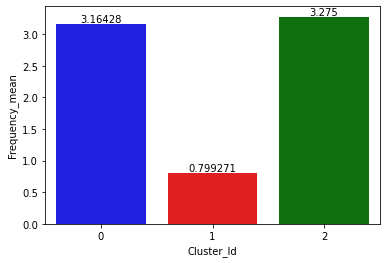

In [69]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Frequency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '0.218197'), Text(0, 0, '0.555369'), Text(0, 0, '0')]

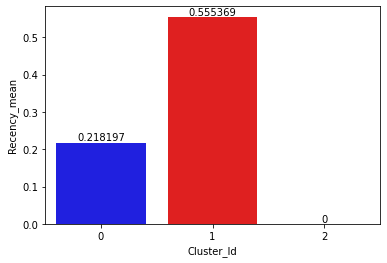

In [70]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Recency_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])


3


[Text(0, 0, '1.22157'), Text(0, 0, '0'), Text(0, 0, '2')]

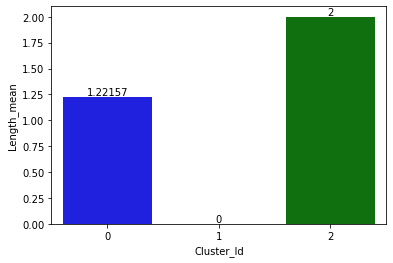

In [71]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Length_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])

3


[Text(0, 0, '0'), Text(0, 0, '0'), Text(0, 0, '1.32102')]

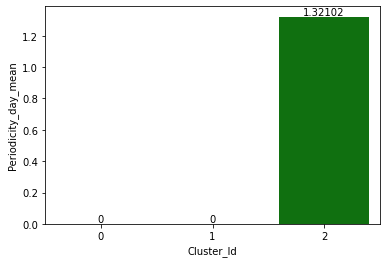

In [72]:
ax=sns.barplot(x=df.Cluster_Id, y=df.Periodicity_day_mean,palette=color_detector(df))
ax.bar_label(ax.containers[0])

### END CLUSTER 2


In [73]:
from sklearn.manifold import TSNE, MDS

dim_red_algo=TSNE(n_components=2, init='pca', random_state=42)
data_2d = dim_red_algo.fit_transform(lrfmp_df_scaled_list[0])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [74]:
# u_labels = np.unique(lrfmp_df_list[0]['Cluster_Id'])
# for u_label in u_labels:
#     cluster_points = lrfmp_df_list[0][(lrfmp_df_list[0]['Cluster_Id'] == u_label)]
#     plt.scatter(cluster_points.iloc[:, 1], cluster_points.iloc[:, 2], label=u_label)

In [75]:
from sklearn.decomposition import PCA
pca_df_list = []
for lrfmp_df_scaled in lrfmp_df_scaled_list:
    pca = PCA(n_components=2)
    #Transform the data
    pca_df = pca.fit_transform(lrfmp_df_scaled)
    pca_df_list.append(pca_df)


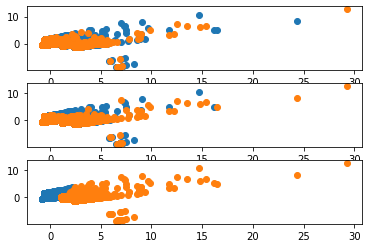

In [76]:
#Initialize the class object
fig, axs = plt.subplots(INTERVAL)

for idx,lrfmp_df_scaled in enumerate(lrfmp_df_scaled_list):
    kmeans = KMeans(n_clusters= 2)
    #predict the labels of clusters.
    label = kmeans.fit_predict(lrfmp_df_scaled)
    #Getting unique labels
    u_labels = np.unique(label)
    for i in u_labels:
        axs[idx].scatter(pca_df[label == i , 0] , pca_df[label == i , 1] , label = i)

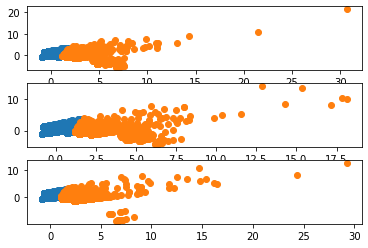

In [77]:
#Initialize the class object
fig, axs = plt.subplots(INTERVAL)

for idx,pca_df in enumerate(pca_df_list):
    kmeans = KMeans(n_clusters= 2)
    #predict the labels of clusters.
    label = kmeans.fit_predict(pca_df)
    #Getting unique labels
    u_labels = np.unique(label)
    for i in u_labels:
        axs[idx].scatter(pca_df[label == i , 0] , pca_df[label == i , 1] , label = i)

In [78]:
# #plotting the results:
# for i in u_labels:
#     plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
# plt.legend()
# plt.show()

In [79]:
def plot_dendrogram(data, model, figsize=(16,10), **kwargs):
    """
    Plots a dendogram using HAC 

    data: pd.DataFrame or np.array
        Time Series Data
    model: Class
        Clustering Model 
    figsize: tuple
        Figure size
    Returns:
    -------
    None 
    """
    model.fit(data)
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    
    plt.figure(figsize=figsize, dpi=200)
    dendrogram(linkage_matrix, **kwargs)
    plt.title('Dendogram')
    plt.xlabel('Objects')
    plt.ylabel('Distance')
    plt.grid(False)
    plt.tight_layout();

In [80]:
# Dendrogram
# model = AgglomerativeClustering(n_clusters=3, linkage='ward', affinity='euclidean', compute_distances=True)

# plot_dendrogram(data=lrfmp_df_scaled_list[0][['Length','Recency','Frequency','Monetary','Periodicity_day']],
#                 model=model,
#                 color_threshold=60)


# TIMESERIES CLUSTERING

## 18 feature

In [81]:
import functools as ft
df_final = ft.reduce(lambda left, right: pd.merge(left, right,on='user_id'), lrfmp_df_list)
df_final.shape

(8361, 21)

In [82]:
# df_final.info()

In [83]:
scaler = StandardScaler()
df_final_scaler = scaler.fit_transform(df_final)
columns_name = df_final.columns


In [84]:
df_final_scaler = pd.DataFrame(df_final_scaler)
df_final_scaler.columns = columns_name
# df_final_scaler

In [85]:
# # Train TimeSeriesKMeans with MDS
# kmeans_model = TimeSeriesKMeans(n_clusters=4, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)
# cluster_labels = kmeans_model.fit_predict(df_final_scaler)

In [86]:
# cluster_unique, cluster_counts = np.unique(cluster_labels, return_counts=True)

# result = np.column_stack((cluster_unique, cluster_counts)) 
# plt.figure(figsize=(16,5))
# plt.bar(cluster_unique, cluster_counts);

In [87]:
df_ts =df_final[[col for col in df_final.columns if 'rank' in col]]
df_ts.columns

Index(['rank_0', 'rank_1', 'rank_2'], dtype='object')

In [88]:
df_ts

,rank_0,rank_1,rank_2
user_id,,,
SlcW7YT835JSzh22o7zRCA==,3.00,3.00,1.00
dLQImlfXMsgSub4OcfJpGg==,3.00,3.00,1.00
J8hrr47CZzyR/nasPNaEcA==,3.00,3.00,3.00
Fh8s6YZs97rvUr/dowRGYA==,1.00,1.00,1.00
Ca2NTs2HdZHIHq1uwiAX4Q==,3.00,3.00,1.00
...,...,...,...
kEC76SpzFfW8FwMhUK/Mqg==,3.00,3.00,3.00
afqB81CeEw/E1xla7P8tiA==,3.00,3.00,3.00
weBOQhMC/VjXvU9QhVlgow==,3.00,3.00,3.00


In [89]:
scaler = StandardScaler()
df_ts_scaler = scaler.fit_transform(df_ts)
columns_name = df_ts.columns

df_ts_scaler = pd.DataFrame(df_ts_scaler)
df_ts_scaler.columns = columns_name
df_ts_scaler

,rank_0,rank_1,rank_2
0,0.51,0.81,-2.45
1,0.51,0.81,-2.45
2,0.51,0.81,0.41
3,-2.02,-1.97,-2.45
4,0.51,0.81,-2.45
...,...,...,...
8356,0.51,0.81,0.41
8357,0.51,0.81,0.41
8358,0.51,0.81,0.41
8359,0.51,0.81,0.41


<AxesSubplot:xlabel='clusters'>

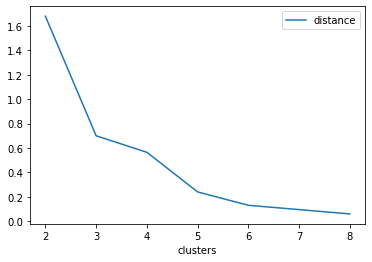

In [121]:
# Elbow-curve/SSD

ssd = {}
range_n_clusters = [2, 3, 4, 5, 6, 8,]

ssd_cluster = []
for num_clusters in range_n_clusters:
    kmeans = TimeSeriesKMeans(n_clusters=num_clusters, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)
    kmeans.fit(df_ts_scaler)
    ssd_cluster.append((num_clusters, kmeans.inertia_))
    

    
# plot the SSDs for each n_clusters
# plt.plot(ssd)
pd.DataFrame(ssd_cluster,columns=['clusters', 'distance']).plot(x='clusters',y='distance')

In [128]:
kmeans_model = TimeSeriesKMeans(n_clusters=4, metric='dtw', n_jobs=-1, max_iter=10, random_state=SEED)
cluster_labels = kmeans_model.fit(df_ts_scaler)
cluster_labels.labels_ 

array([2, 2, 1, ..., 1, 1, 1], dtype=int64)

In [129]:
df_ts['main_cluster'] = cluster_labels.labels_ 

C:\Users\MHS\AppData\Local\Temp\ipykernel_6276\3221818745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ts['main_cluster'] = cluster_labels.labels_


In [125]:
df_ts

,rank_0,rank_1,rank_2,main_cluster
user_id,,,,
SlcW7YT835JSzh22o7zRCA==,3.00,3.00,1.00,2
dLQImlfXMsgSub4OcfJpGg==,3.00,3.00,1.00,2
J8hrr47CZzyR/nasPNaEcA==,3.00,3.00,3.00,1
Fh8s6YZs97rvUr/dowRGYA==,1.00,1.00,1.00,2
Ca2NTs2HdZHIHq1uwiAX4Q==,3.00,3.00,1.00,2
...,...,...,...,...
kEC76SpzFfW8FwMhUK/Mqg==,3.00,3.00,3.00,1
afqB81CeEw/E1xla7P8tiA==,3.00,3.00,3.00,1
weBOQhMC/VjXvU9QhVlgow==,3.00,3.00,3.00,1


In [106]:

# #Getting unique labels
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(projection='3d')

# u_labels = np.unique(cluster_labels.labels_)
# for i in u_labels:
#     ax.scatter(df_ts[df_ts['main_cluster'  ]== i]['Cluster_Id'] , df_ts[df_ts['main_cluster']== i]['Cluster_Id_x'] ,df_ts[df_ts['main_cluster'  ]== i]['Cluster_Id_y'], label = i)
# plt.legend()
# plt.show()

In [107]:
def plot_cluster_ts(current_cluster):
    """
    Plots time series in a cluster 

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),4,
        figsize=(45, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        
        ax[indx].plot(series)
        plt.xticks(rotation=45)

        
    plt.tight_layout()
    plt.show();

In [108]:
u_labels


array([0, 1])

==========Cluster number: 0==========


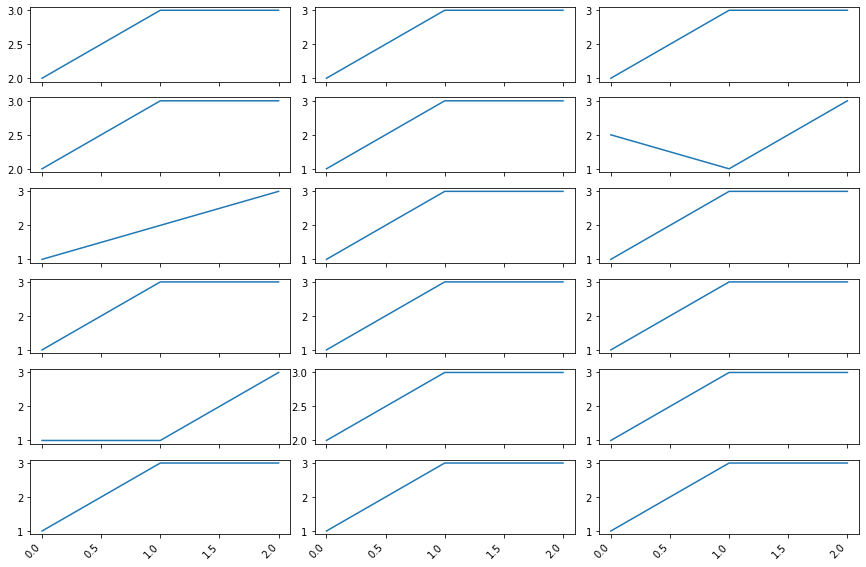

==========Cluster number: 1==========


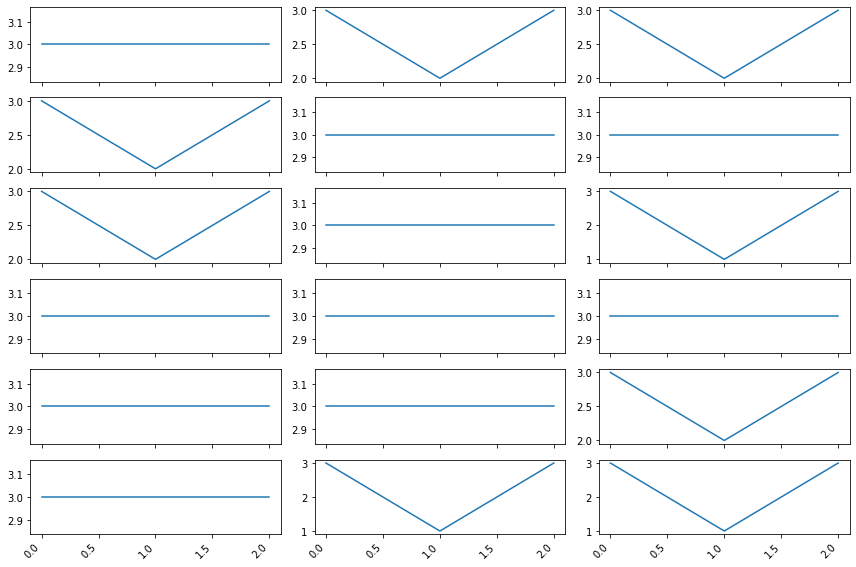

==========Cluster number: 2==========


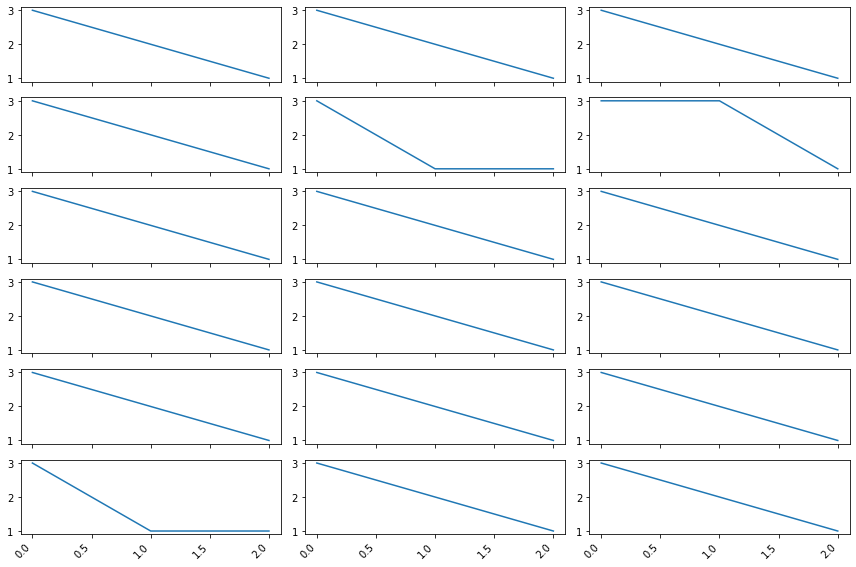

==========Cluster number: 3==========


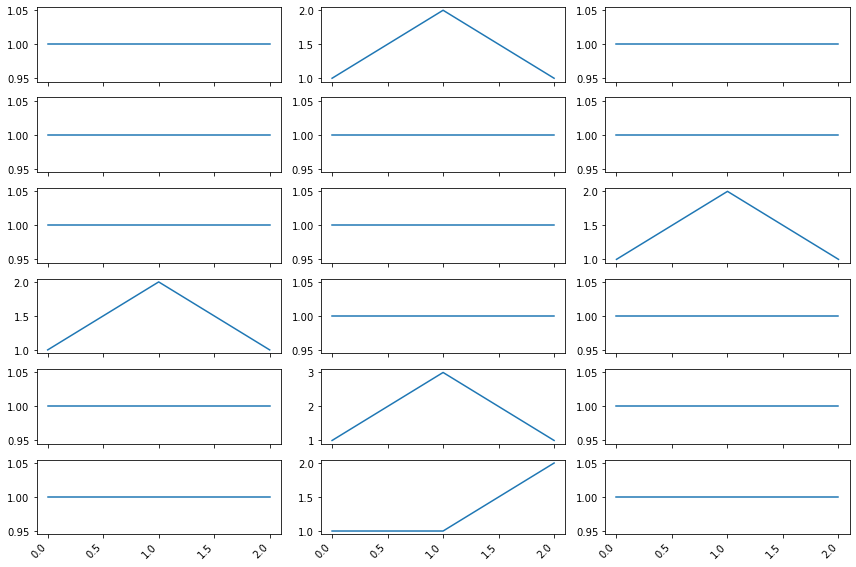

In [131]:


for cluster in range(4):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(df_ts[df_ts['main_cluster']== cluster].sample(n = 18).values[: , :3])

In [110]:
def plot_cluster_ts(current_cluster):
    """
    Plots time series in a cluster 

    current_cluster: np.array
        Cluster with time series 
    Returns:
    -------
    None 
    """
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/3)),3,
        figsize=(12, 8)
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)
    for indx, series in enumerate(current_cluster):
        
        ax[indx].plot(series)
        plt.xticks(rotation=45)

        
    plt.tight_layout()
    plt.show();

==========Cluster number: 0==========


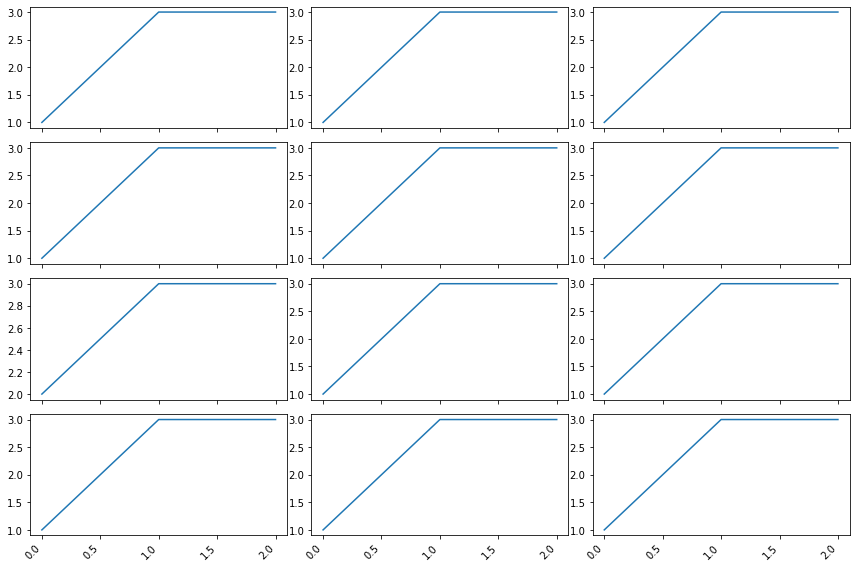

==========Cluster number: 1==========


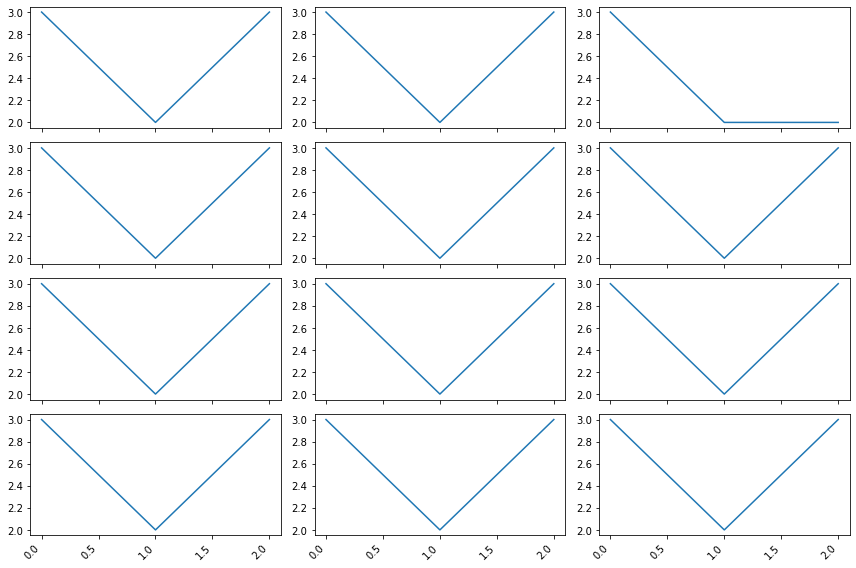

==========Cluster number: 2==========


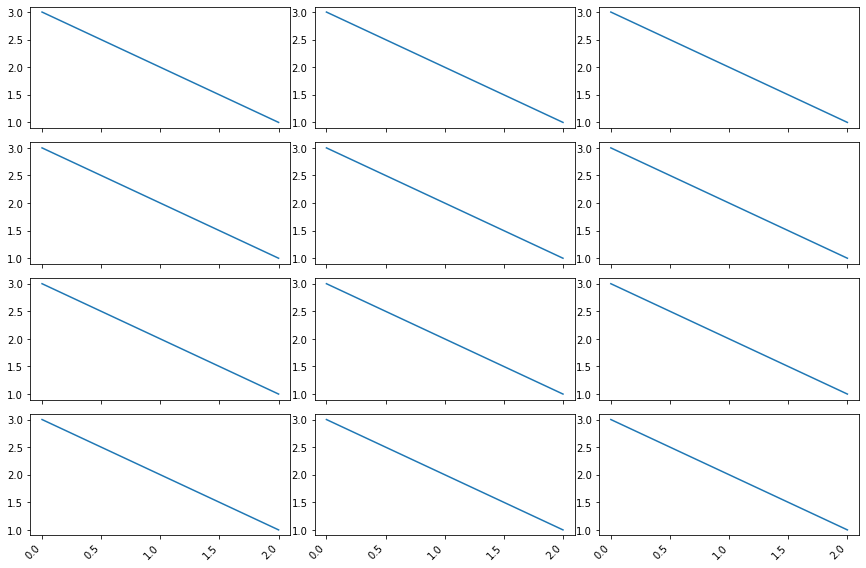

==========Cluster number: 3==========


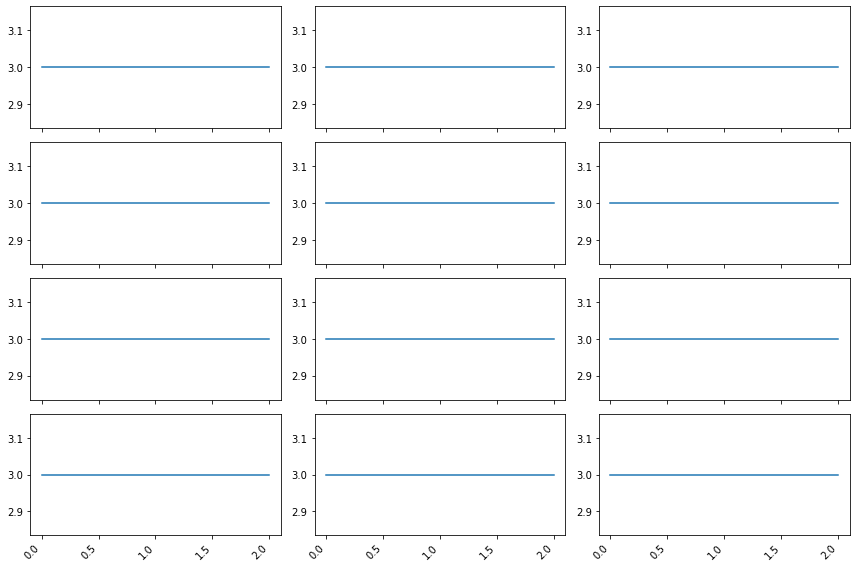

==========Cluster number: 4==========


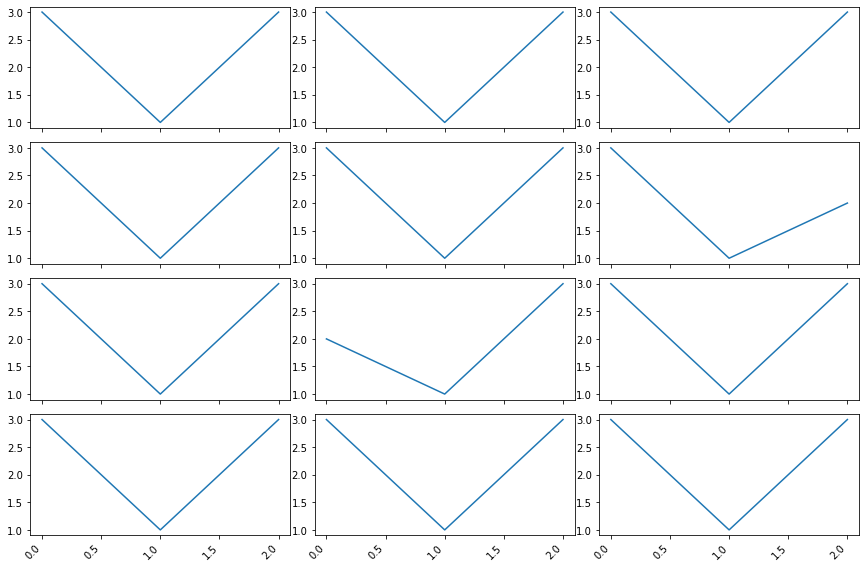

==========Cluster number: 5==========


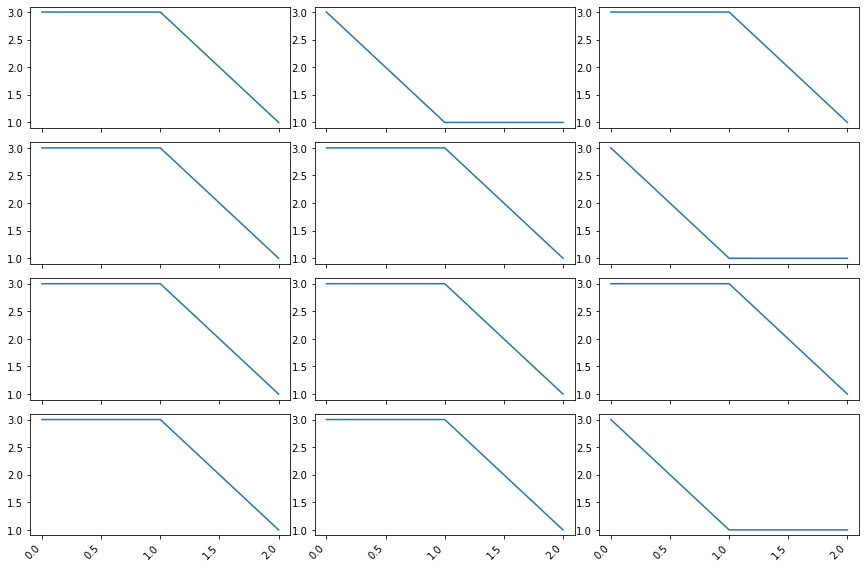

==========Cluster number: 6==========


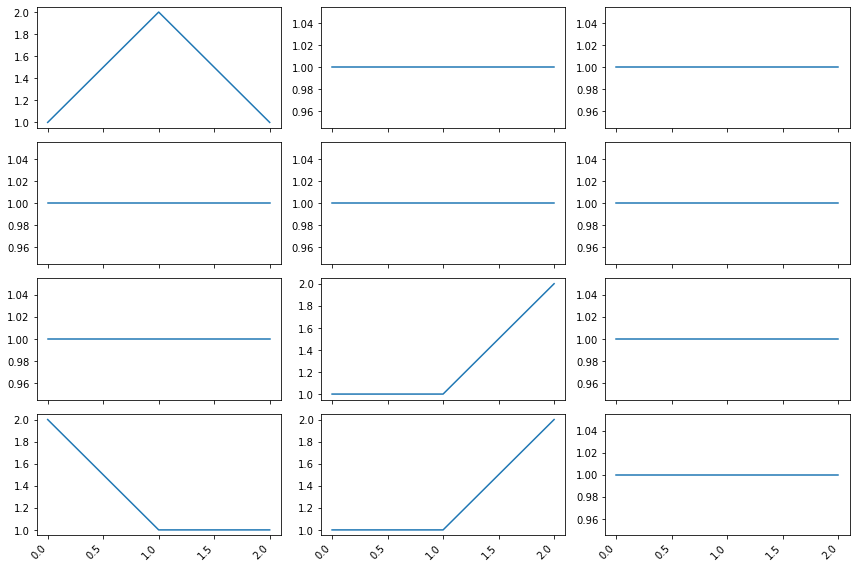

==========Cluster number: 7==========


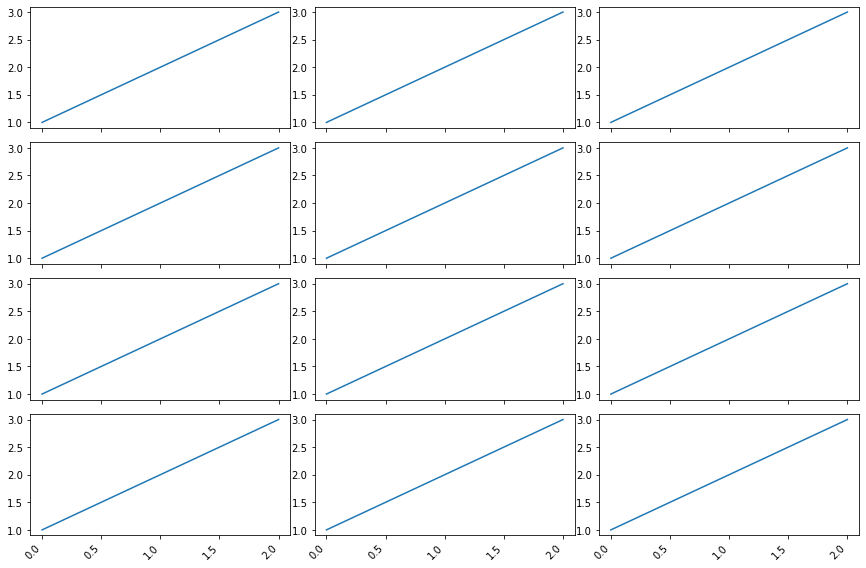

In [113]:
for cluster in range(8):
    print(f"==========Cluster number: {cluster}==========")
    plot_cluster_ts(df_ts[df_ts['main_cluster']== cluster].sample(n = 12).values[: , :3])